### Libraries

In [169]:
# Libraries
import pandas as pd # For the amortisation schedule
import datetime # For display the loan start date
from dateutil.relativedelta import relativedelta # Used for incrementing the months
from IPython.display import clear_output, display # Used for input validation and for displaying output
import ipywidgets as widgets
import traitlets # used for linking values together to prevent (for example) the deposit being higher than the purchase price
import matplotlib.pyplot as plt

### Mortgage Class

In [170]:
class Mortgage():
    """
    A simple mortgage calculator
    """
    
    def __init__(self,purchase_price,deposit,interest_rate,loan_term,start_date,currency):
        # Attributes
        self.purchase_price = purchase_price
        self.deposit = deposit
        self.interest_rate = interest_rate
        self.loan_term = loan_term
        self.start_date = start_date
        self.currency = currency
        
        # Calculations
        self.principal = self.purchase_price-self.deposit
        self.loan_to_value = round((self.principal/self.purchase_price)*100)
        self._monthly_interest_rate = (self.interest_rate/12)/100 # Divided by 12 to get monthly percentage, then by 100 to get decimal         
        self.number_of_repayments = self.loan_term*12
        self.monthly_repayments = round(self.principal*(self._monthly_interest_rate*(1+self._monthly_interest_rate)**self.number_of_repayments)/(((1+self._monthly_interest_rate)**self.number_of_repayments-1)),2)
        self.total_payments = round((self.monthly_repayments*self.number_of_repayments))
        self.total_interest = round((self.total_payments-self.principal))
    
    def generate_schedule(self):
        """
        Returns an amortisation schedule.
        """
        
        # Amortisation calculations
        payment_number = list(range(1, self.number_of_repayments + 1))
        payment_date = [(self.start_date + relativedelta(months=x)).strftime("%d/%m/%Y") for x in range(1,self.number_of_repayments + 1)]
        interest_payment = [round((self.principal * self._monthly_interest_rate), 2)]
        principal_payment = [round(((self.monthly_repayments) - interest_payment[0]), 2)]
        remaining_balance = [round((self.principal - principal_payment[0]), 2)]

        for _ in range(1,self.number_of_repayments):
            interest_payment.append(round((remaining_balance[-1] * self._monthly_interest_rate), 2))
            principal_payment.append(round((self.monthly_repayments - interest_payment[-1]), 2))
            remaining_balance.append(round((remaining_balance[-1] - principal_payment[-1]), 2))

        # Data Frame Display
        schedule_data = pd.DataFrame({
            'Payment Number':payment_number,
            'Payment Date':payment_date,
            'Interest Payment':interest_payment,
            'Principal Payment':principal_payment,
            'Remaining Balance':remaining_balance})
        
        # Graph Display
        schedule_data.plot(x='Payment Date',y=['Interest Payment','Principal Payment'],kind='line')
        plt.xlabel('Payment Date')
        plt.ylabel(f'Monthly Payments ({self.currency})')
        plt.title('Monthly Interest Rate vs Principal Payments')
        plt.legend(['Interest Payment','Principal Payment'])
        plt.tick_params(axis='x', rotation=45)
        
        # Returning Values
        return schedule_data,plt
        

### Declaring User Input GUI

In [171]:
# Currency
currency_label = widgets.Label(value='Currency:')
currency_widget = widgets.Dropdown(options=['£','$','€'],layout=widgets.Layout(width='200px')) # Gives the currency options
def currency_change(change): # This function is used to adjust the description of the purchase price and deposit currencies when the dropdown changes
    purchase_price_widget.description = currency_widget.value
    deposit_widget.description = currency_widget.value
    monthly_repayments_widget.description = currency_widget.value
    principal_widget.description = currency_widget.value
    total_interest_widget.description = currency_widget.value
    total_payments_widget.description = currency_widget.value
    
currency_widget.observe(currency_change,'value') # This observe is triggered when the currency dropdown changes
    
# Purchase Price 
purchase_price_label = widgets.Label(value='Purchase Price:')
purchase_price_widget = widgets.BoundedIntText(value=280000,description = '£',min=1,max=10**18)
purchase_price_widget.style.description_width = 'initial' # Resets the width of the description to make as small as possible

# Deposit 
deposit_label = widgets.Label(value='Deposit:')
deposit_widget = widgets.BoundedIntText(value=50000,description = '£',min=1,max=10**18)
deposit_widget.style.description_width = 'initial' # Resets the width of the description to make as small as possible

# Interest rate 
interest_rate_label = widgets.Label(value='Interest Rate:')
interest_rate_widget = widgets.BoundedFloatText(value=5.5,min=0,max=100)
interest_rate_with_percentage = widgets.HBox([interest_rate_widget, widgets.Label('%')]) # This horizontal box puts the interest rate text box to the left of a % symbol

# Loan Term 
loan_term_label = widgets.Label(value='Loan Term:')
loan_term_widget = widgets.BoundedIntText(value=25,min=1,max=50)
loan_term_with_years = widgets.HBox([loan_term_widget, widgets.Label('Year(s)')])

# Start Date
start_date_label = widgets.Label(value='Start Date:')
start_date_widget = widgets.DatePicker(value=datetime.date.today())

# Links
widgets.dlink((purchase_price_widget,'value'),(deposit_widget,'max')) # Sets the value of the purchase price to be the maximum deposit amount
widgets.dlink((deposit_widget,'value'),(purchase_price_widget,'min')) # Sets the value of the deposit to be the maximum purchase price amount

# Calculate Button
calculate_button = widgets.Button(description='Calculate')
def calculate(c):
    # Instantiating the mortgage class
    global mortgage
    mortgage = Mortgage(purchase_price_widget.value,
                        deposit_widget.value,
                        interest_rate_widget.value,
                        loan_term_widget.value,
                        start_date_widget.value,
                        currency_widget.value)
    # Resetting Display
    clear_output()
    display(gui_hbox)
    
    # Setting the GUI elements to display the mortgage properties
    monthly_repayments_widget.value = str(f'{mortgage.monthly_repayments:,.2f}')
    principal_widget.value = str(f'{mortgage.principal:,}')
    ltv_widget.value = str(f'{mortgage.loan_to_value:,}')
    total_interest_widget.value = str(f'{mortgage.total_interest:,}')
    total_payments_widget.value = str(f'{mortgage.total_payments:,}')
    schedule,graph = mortgage.generate_schedule()  
    display(schedule);
    graph.show();

calculate_button.on_click(calculate)

# Adjusting Widget Widths
widget_width = '200px'
currency_widget.layout.width = widget_width
purchase_price_widget.layout.width = widget_width
deposit_widget.layout.width = widget_width
interest_rate_widget.layout.width = widget_width
loan_term_widget.layout.width = widget_width
start_date_widget.layout.width = widget_width
calculate_button.layout.width = widget_width

# User Input VBox
user_input_vbox = widgets.VBox([currency_label,currency_widget,
                               purchase_price_label,purchase_price_widget,
                              deposit_label,deposit_widget,
                              interest_rate_label,interest_rate_with_percentage,
                                loan_term_label,loan_term_with_years,
                              start_date_label,start_date_widget,
                              calculate_button])

### Declaring Calculations GUI

In [172]:
def calculations_gui_declaring(label_text):
    label = widgets.Label(value=f'{label_text}:')
    widget = widgets.Text(placeholder=label_text,description = '£',disabled=True)
    widget.style.description_width = 'initial'
    widget.layout.width = '200px'
    return label, widget
    

# Monthly Repayments
monthly_repayments_label,monthly_repayments_widget = calculations_gui_declaring('Monthly Repayments')

# Principal
principal_label,principal_widget = calculations_gui_declaring('Principal')

# LTV
ltv_label = widgets.Label(value='LTV:')
ltv_widget = widgets.BoundedFloatText(min=0,max=100,disabled=True)
ltv_widget_with_percentage = widgets.HBox([ltv_widget, widgets.Label('%')]) # This horizontal box puts the interest rate text box to the left of a % symbol
ltv_widget.layout.width = '200px'

# Total Interest
total_interest_label,total_interest_widget = calculations_gui_declaring('Total Interest')

# Total Payments
total_payments_label,total_payments_widget = calculations_gui_declaring('Total Payments')

# Calculations VBox
calculations_vbox = widgets.VBox([monthly_repayments_label,monthly_repayments_widget,
                                 principal_label,principal_widget,
                                 ltv_label,ltv_widget_with_percentage,
                                 total_interest_label,total_interest_widget,
                                 total_payments_label,total_payments_widget])

### Final GUI HBox

In [173]:
gui_hbox = widgets.HBox([user_input_vbox,calculations_vbox])

### Displaying the GUI

,Payment Number,Payment Date,Interest Payment,Principal Payment,Remaining Balance
0,1,26/02/2024,1008.33,342.66,219657.34
1,2,26/03/2024,1006.76,344.23,219313.11
2,3,26/04/2024,1005.19,345.80,218967.31
3,4,26/05/2024,1003.60,347.39,218619.92
4,5,26/06/2024,1002.01,348.98,218270.94
...,...,...,...,...,...
295,296,26/09/2048,30.55,1320.44,5344.24
296,297,26/10/2048,24.49,1326.50,4017.74
297,298,26/11/2048,18.41,1332.58,2685.16
298,299,26/12/2048,12.31,1338.68,1346.48


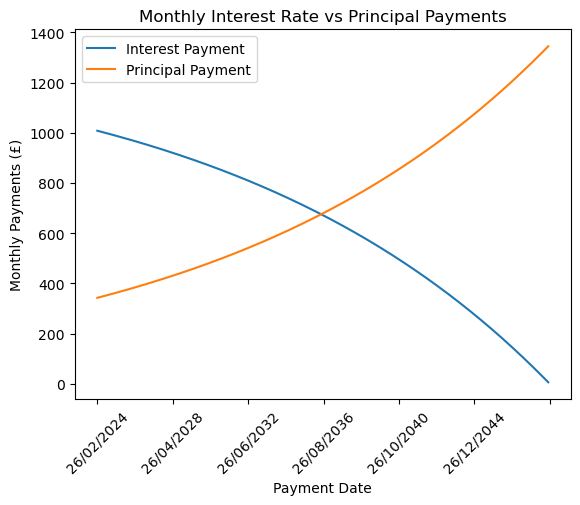

In [174]:
display(gui_hbox)